In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import parent
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data


In [4]:

BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4


phi = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)
psi = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)

net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phi, psi),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)

network_wrappers.assignIdentityMap(net, input_shape)

net.load_state_dict(torch.load("../results/affine_knee_pretrain_2/knee_aligner_resi_net300"))

<All keys matched successfully>

In [21]:
_, medresknees = data.get_knees_dataset()

100%|██████████| 240/240 [00:11<00:00, 20.71it/s]


In [58]:
net.cuda()

InverseConsistentAffineNet(
  (regis_net): ConvolutionalMatrixNet(
    (convs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (dense2): Linear(in_features=512, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=12, bias=True)
  )
)

In [59]:
def make_batch():
    image = torch.cat([random.choice(medresknees) for _ in range(BATCH_SIZE)])
    image = image[:, None]
    image = image.cuda()
    return image

In [24]:
moving_image, fixed_image = make_batch(), make_batch()

In [60]:
net(moving_image, fixed_image)

[tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2201, device='cuda:0', grad_fn=<MulBackward0>)]

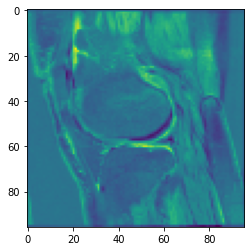

In [65]:
plt.imshow(fixed_image[
    
    N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())

##plt.imshow(net.warped_image_A[0, 0, 10].cpu().detach())
#plt.show()
#plt.imshow(net.warped_image_B[0, 0, 10].cpu().detach())

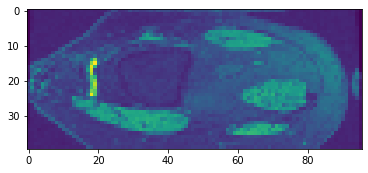

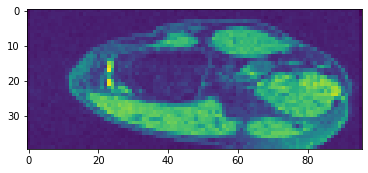

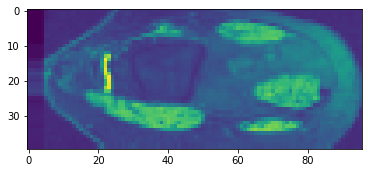

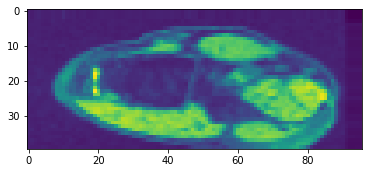

In [62]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

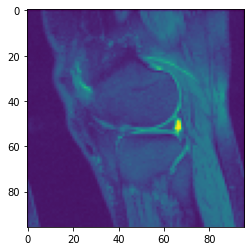

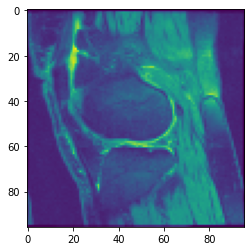

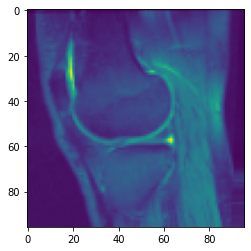

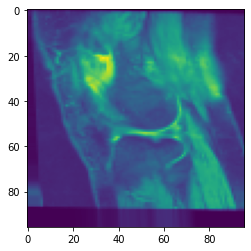

In [64]:
import matplotlib.pyplot as plt
N = 4

plt.imshow(moving_image[4, 0, 10].cpu())
plt.show()
plt.imshow(fixed_image[4, 0, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[4, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[4, 0, 10].cpu().detach())

In [56]:
net.matrix_AB[20].cpu().detach().numpy()

array([[ 0.9844828 ,  0.01737089,  0.00975137, -0.02261346],
       [ 0.01109852,  1.0967466 , -0.02238288,  0.01230571],
       [ 0.00101198, -0.03634198,  0.9523689 ,  0.0642276 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [49]:
import numpy as np
np.set_printoptions(suppress=True)